In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from google.colab import files

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import files

In [50]:
!pip install -U -q kaggle
files.upload()
!cp kaggle.json /root/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle (3).json
 99% 1.14G/1.15G [00:13<00:00, 80.9MB/s]
100% 1.15G/1.15G [00:13<00:00, 93.6MB/s]


In [51]:
!apt install pv
!unzip -o /content/chest-xray-pneumonia.zip  | pv -l >/dev/null
os.remove('chest-xray-pneumonia.zip')
!unzip -o /content/chest_xray.zip  | pv -l >/dev/null
os.remove('chest_xray.zip')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pv is already the newest version (1.6.6-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
2.00  0:00:09 [ 206m/s] [  <=>                                                 ]
11.7k 0:00:15 [ 780 /s] [                <=>                                   ]


In [52]:

base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
preds=Dense(2,activation='softmax')(x)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [54]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [55]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

train_generator=train_datagen.flow_from_directory('/content/chest_xray/train/',
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical', shuffle=True)


model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Found 5216 images belonging to 2 classes.
Epoch 1/5
163/163 [==============================] - 72s 443ms/step - loss: 0.1358 - acc: 0.9555
Epoch 2/5
163/163 [==============================] - 68s 415ms/step - loss: 0.0468 - acc: 0.9850
Epoch 3/5
163/163 [==============================] - 68s 419ms/step - loss: 0.0542 - acc: 0.9831
Epoch 4/5
163/163 [==============================] - 69s 421ms/step - loss: 0.0531 - acc: 0.9843
Epoch 5/5
163/163 [==============================] - 68s 416ms/step - loss: 0.0172 - acc: 0.9948


In [0]:

def get_rez(pic):
  img = image.load_img(pic, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  p_good,p_ill = np.around(model.predict(x), decimals=2)[0]
  return{'p_good':p_good,'p_ill':p_ill}

In [0]:
from google.colab import files

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
path = '/content/sample2.jpg'

Populating the interactive namespace from numpy and matplotlib


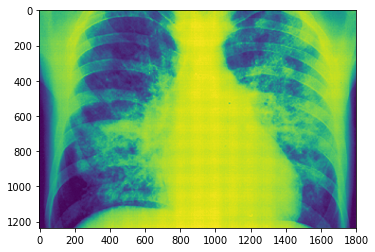

In [71]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(path)
plt.imshow(img)
#plt.show()

In [69]:
print(get_rez(path))

{'p_good': 0.0, 'p_ill': 1.0}
